In [2]:
library("ggplot2")

# Problem 11: Flat Bayesian priors

Many reactions, including between biomolecules involved in cell signaling, gene expression, obey simple chemical reaction where the amount of active molecule is given by

$$\frac{dx}{dt} = k_{\textrm{on}} - k_{\textrm{off}} x$$

and often there is measurement noise 

$$y = x + \epsilon$$

where $\epsilon$ is Gaussian distributed with standard deviation $\sigma$.



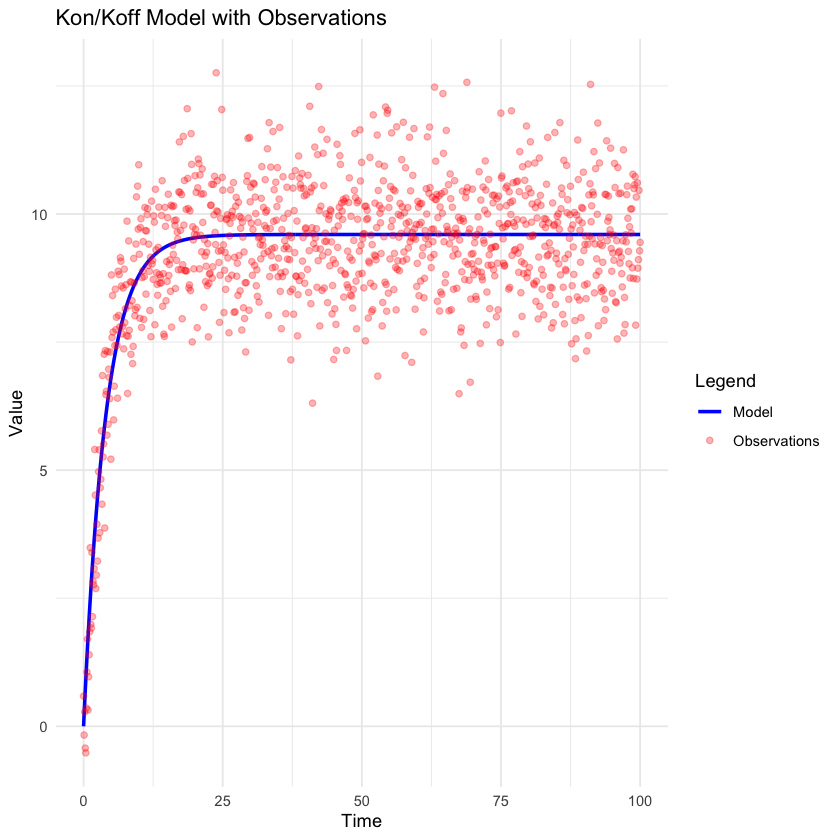

In [10]:
# Generate synthetic data
# Let's simulate the reaction

# solution to first-order kinetics

NSample = 1000 # sample size
sigma_gt <- 1 # observation noise

# parametrize by kon and koff

kon_gt <- 2.4
koff_gt <- 0.25


tStart <- 0
tStop <- 100
times <- seq(from=tStart,to=tStop,by=(tStop-tStart)/(NSample-1))


x <- kon_gt/koff_gt*(1-exp(-koff_gt*times))
soln <- data.frame( "x"=x, "times"=times)

# add noise
y <- x + rnorm(NSample,0,sigma_gt)
soln$observations = y

# Create the plot
ggplot(soln, aes(x=times)) +
  geom_line(aes(y=x, color="Model"), size=1) +
  geom_point(aes(y=observations, color="Observations"), alpha=0.3) +
  labs(title="Kon/Koff Model with Observations",
       x="Time",
       y="Value",
       color="Legend") +
  scale_color_manual(values=c("Model"="blue", "Observations"="red")) +
  theme_minimal()


Given time series data of $x(t)$, we will try to discover the values of paramaters ``kon``, ``koff`` and ``sigma`` using Markov Chain Monte Carlo (MCMC).

To perform MCMC, we must choose priors.
We make the simplest assumption and use flat priors, subject to non-negativity (we require kon>0, koff>0 and sigma>0). 

Below is a code snippet that implements MCMC to learn the parameters of the model. 

In [12]:
# define the likelihood function

logLikelihood <- function(param,times,y){
    kon = param[1]
    koff = param[2]
    sigma = param[3]
    
    pred = kon/koff*(1-exp(-koff*times))

    singleLikelihoods = dnorm(y, mean=pred, sd=sigma, log=T) # really the log likelihood
    sumLikelihood = sum(singleLikelihoods) # really the log of the product of likelihoods
        
    return(sumLikelihood)
    
}

# Here is the Metropolis algorithm

proposalGenerator <- function(currentParam){
    
    proposalParam = rnorm(3, mean=currentParam, sd = c(0.002,0.0002,0.001)) 
    # play with these to make the acceptance rates around 30% for most efficient MCMC
    proposalParam[proposalParam<0] <- 0 # Prevent negative values
    return(proposalParam)
}

run_metropolis_MCMC <- function(startvalue, iterations){
    chain = array(dim = c(iterations+1,3))
    chain[1,] = startvalue
    for (i in 1:iterations){
        
        proposal = proposalGenerator(chain[i,])
         
        # This is the Metropolis-Hastings ("Boltzmann") test
        probab = exp(logLikelihood(proposal,times,y) - logLikelihood(chain[i,],times,y))    
        if (runif(1) < probab){
            chain[i+1,] = proposal
        }
        else{
            chain[i+1,] = chain[i,]
        }
    }
    return(chain)
}


The code block below runs the MCMC algorithm.
Note: depending on the number of iterations, this could take several minutes on your computer. 

In [13]:
startvalue = c(1,0.1,0.1)
iterations = 100000

# Run the MCMC learning
# Note: This is a long run, so you may want to reduce the number of iterations for testing
chain = run_metropolis_MCMC(startvalue, iterations)
 
burnIn = 10000
acceptance = 1-mean(duplicated(chain[-(1:burnIn),]))

## Question i

The output of MCMC is a sample of values of the parameters $k_{\textrm on}$, $k_{\textrm{off}}$ and $\sigma$ that represent the posterior distribution.

Plot the sequence of parameter values.
What is the acceptance rate?
Does it look converged? If not, adjust the MCMC hyperparameters and repeate the learning run.

Acceptance rate:  0.8919234 


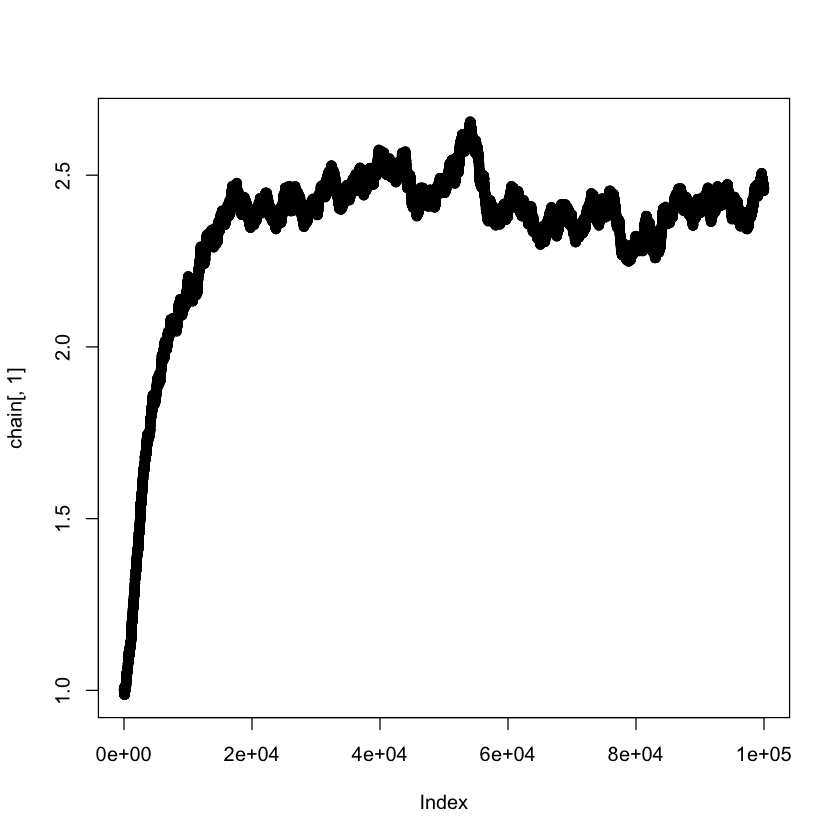

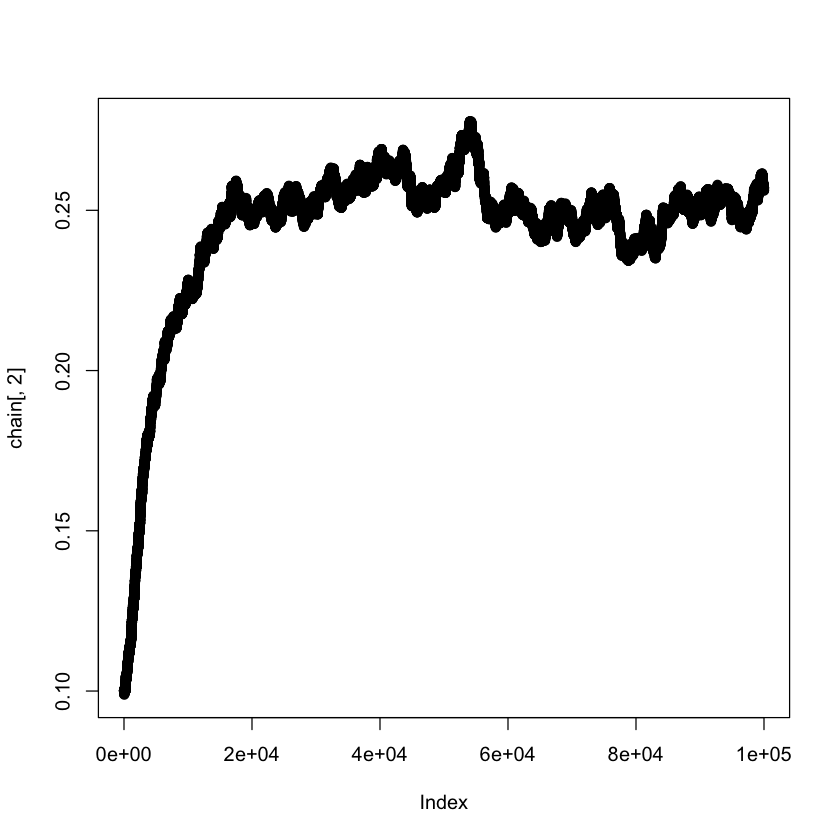

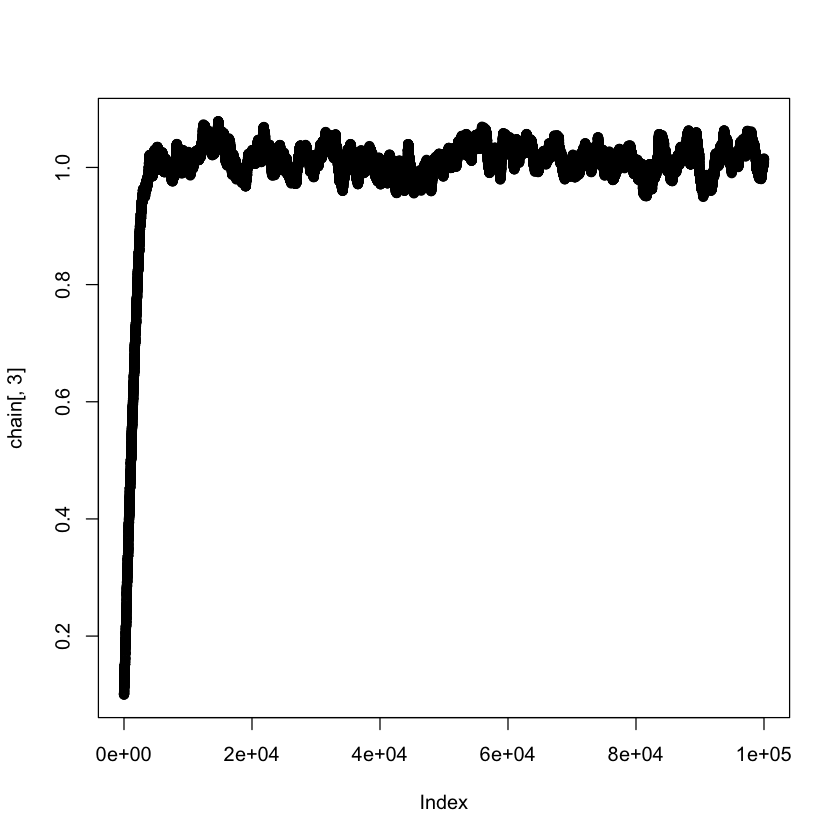

In [24]:
cat("Acceptance rate: ", acceptance, "\n")

plot(chain[,1])
plot(chain[,2])
plot(chain[,3])

Plot the 3 histograms of $k_{\textrm{on}}$, koff and sigma. Add an indicator at the ground truth value.

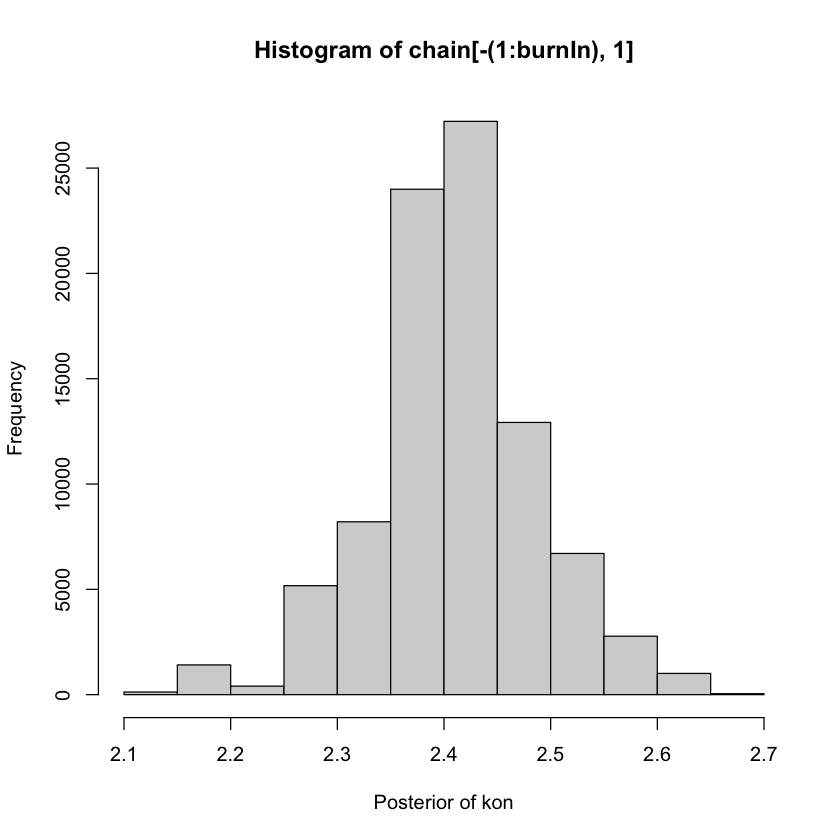

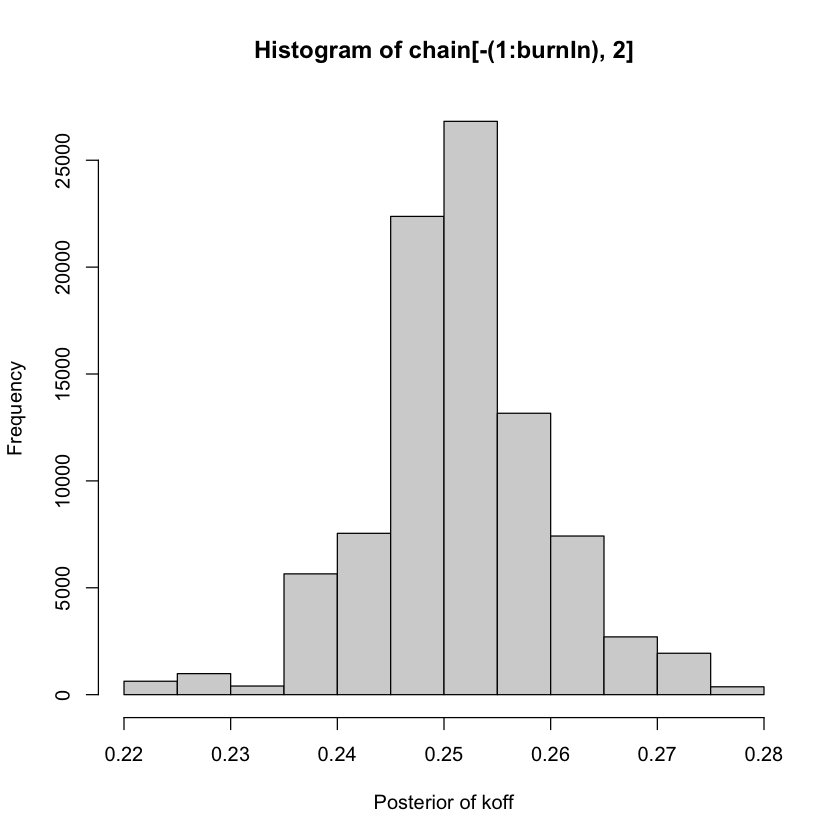

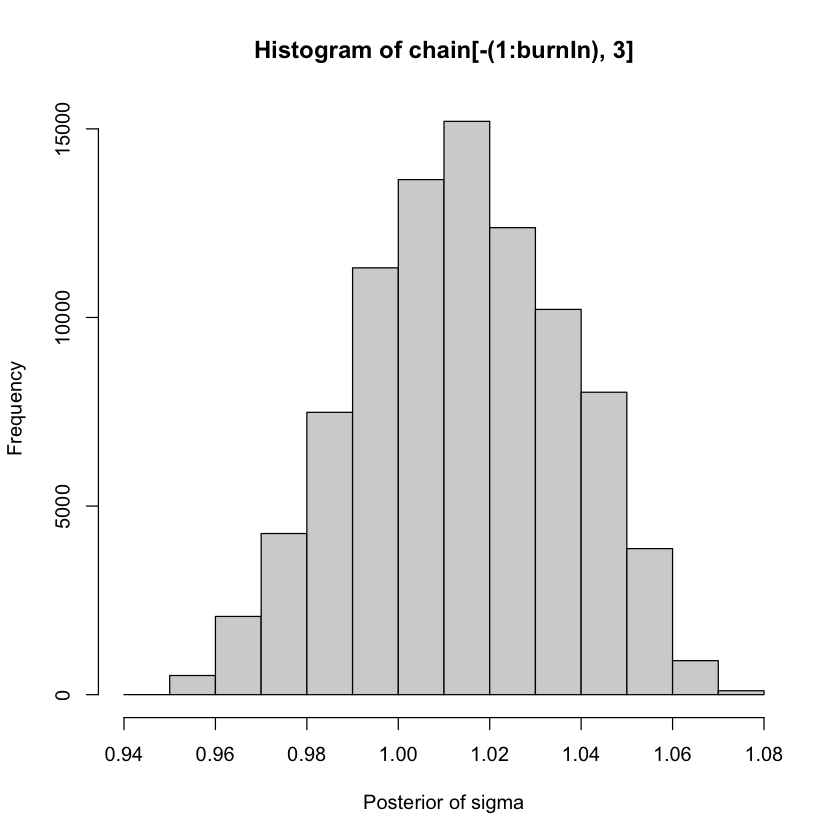

In [23]:
# Plot the sequence of parameter values
hist(chain[-(1:burnIn),1], xlab="Posterior of kon")
hist(chain[-(1:burnIn),2], xlab="Posterior of koff")
hist(chain[-(1:burnIn),3], xlab="Posterior of sigma")

Plot 3 two-dimensional histgrams of each pair of parameters. Add an indicator at the ground truth value.

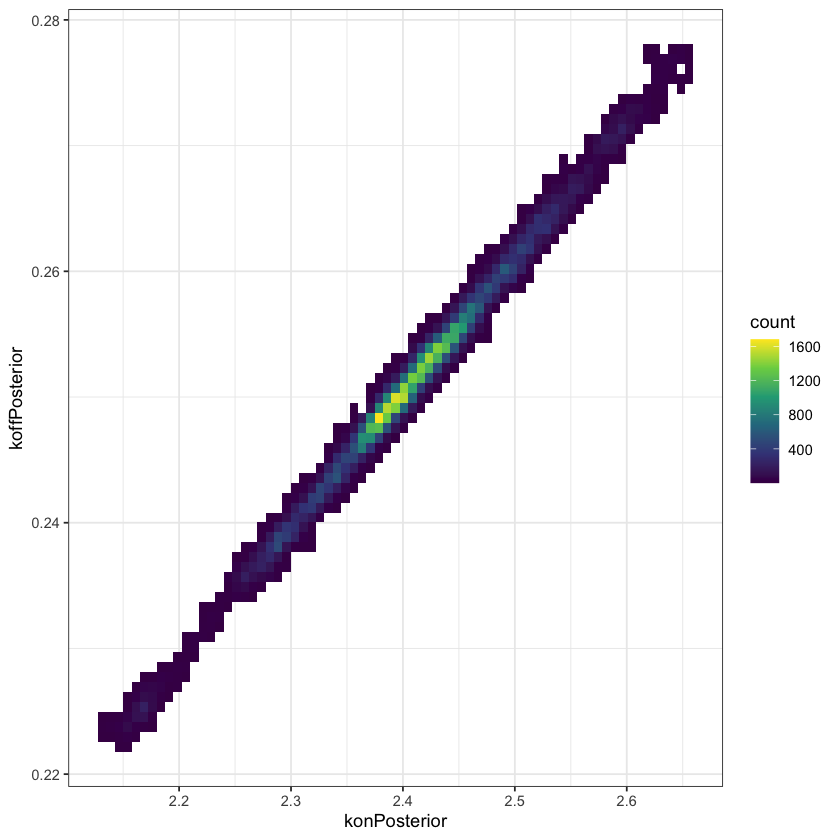

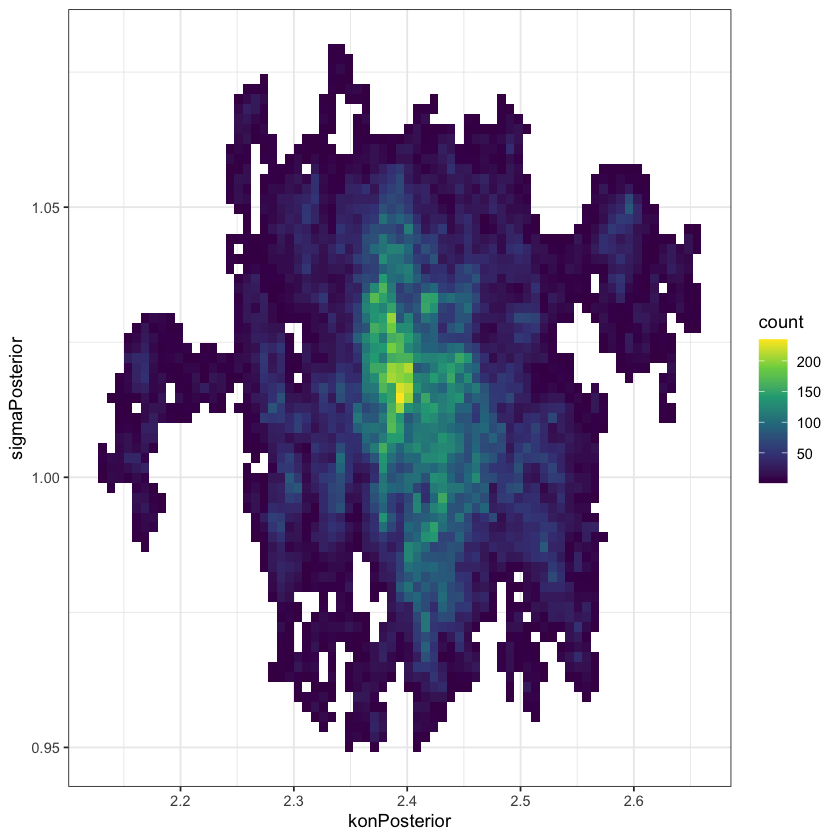

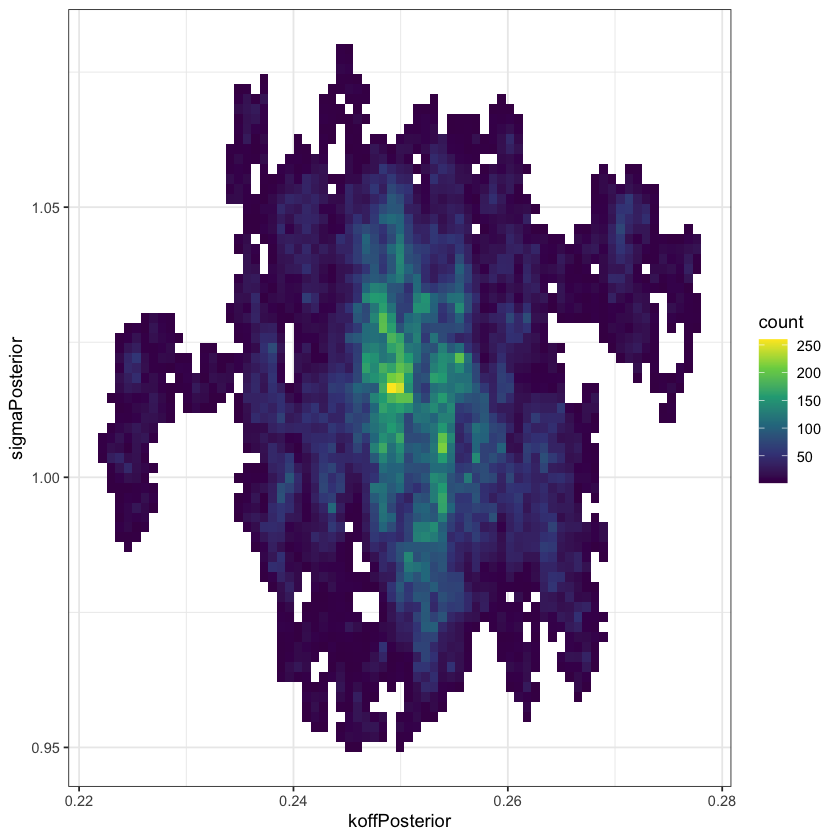

In [22]:
dfChain <- data.frame(konPosterior=chain[-(1:burnIn),1], 
                      koffPosterior=chain[-(1:burnIn),2],
                      sigmaPosterior=chain[-(1:burnIn),3] )

ggplot(dfChain, aes(x=konPosterior, y=koffPosterior) ) +
  geom_bin2d(bins = 70) +
  scale_fill_continuous(type = "viridis") +
  theme_bw()

ggplot(dfChain, aes(x=konPosterior, y=sigmaPosterior) ) +
  geom_bin2d(bins = 70) +
  scale_fill_continuous(type = "viridis") +
  theme_bw()

ggplot(dfChain, aes(x=koffPosterior, y=sigmaPosterior) ) +
  geom_bin2d(bins = 70) +
  scale_fill_continuous(type = "viridis") +
  theme_bw()

## Question ii

The chemical reaction we simulated is mathematically identical to 

$$\frac{dx}{dt} = \frac{1}{\tau}\left( K_A -  x \right)$$

where $\tau$ is the timescale of the reaction and $K_A$ is the affinity. 
(Aside: another often-discussed quantity is the dissociation constant $K_D = 1/K_A$.) 

Show that the chemical reaction with $K_D$ and $\tau$ is identical to the first one with $k_{\rm on}$ and $k_{\rm off}$. Find the relationship between the two sets of parameters.

## Question iii

In this problem, we will MCMC to fit the simulated data to discover the values of paramaters ``KD``, ``tau`` and ``sigma`` (the same as above, the standard deviation of the observational noise).

To perform MCMC, we must choose priors. We make the simplest assumption and use flat priors, subject to non-negativity (we require KD>0, tau>0 and sigma>0). 

Edit the MCMC code to perform MCMC learning to the equation with K_A, tau and sigma.

Make the same plots as in Question i:

* Plot the sequence of parameter values. Does it look converged? If not, adjust the MCMC hyperparameters and repeate the learning run.

* Plot the 3 histograms of $\tau$, K_A and sigma. Add an indicator at the ground truth value.

* Plot 3 two-dimensional histgrams of each pair of parameters. 



In [ ]:
# CODE HERE

## Question iv

Take the posterior sample from Question iii and transform these to $koff$ and $kon$. 

PLot the 3 histograms of $koff$ and $kon$ and $sigma$, and the 3 two-dimensional histograms of pairs of parameters.
Compare these to question i. 

Which posterior estimates have a tighter distribution?
Which posterior estimates are closer to the ground truth?


In [ ]:
# CODE HERE